### 가위바위보 분류기 만들기
루브릭 및 과정
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?  
학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음  
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음  
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
60% 이상 도달

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.9.1
1.21.5


데이터 로드 및 Resize  
촬영한 사진 데이터를 불러오고, 28*28로 resize할 것

In [2]:
from PIL import Image
import glob
import os

In [3]:
# 데이터셋 변환, 한번만 할 것
r_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\rock'
s_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\scissor'
p_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\paper'

os.chdir('C:\\Users\\wader\\workplace')
print(os.getcwd())

C:\Users\wader\workplace


In [4]:
def resize_images(path):
    img_list=os.listdir(path)
    target_size=(28,28)
    os.chdir(path)
    for i in img_list:
        full_path=os.path.join(path, i)
        big_img=Image.open(full_path)
        sm_img=big_img.resize(target_size, Image.ANTIALIAS)
        sm_img.save(i, "JPEG")

In [5]:
resize_images(r_path)
resize_images(s_path)
resize_images(p_path)

C:\Users\wader\AppData\Local\Temp\ipykernel_30980\2826604337.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  sm_img=big_img.resize(target_size, Image.ANTIALIAS)


이미지 파일을 적절하게 불러오기 위해, 교육 자료에서 제시한 함수를 수정하여 사용하였다. load_data()는 실행시 img_path로부터 rock, scissor, paper의 세 폴더에 들어가서 각 값들을 불러온다.(img_path에 rock, scissor, paper의 폴더가 각각 필요하다.)

In [6]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    
    sci_list=os.listdir(img_path+'scissor\\')
    rok_list=os.listdir(img_path+'rock\\')
    pap_list=os.listdir(img_path+'paper\\')
    
    
    for file in sci_list:
        file= img_path+'scissor\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in rok_list:
        file= img_path+'rock\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in pap_list:
        file= img_path+'paper\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\rock_scissor_paper\\"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

test_dir_path = "C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\test\\rock_scissor_paper\\"
(x_test, y_test)=load_data(test_dir_path)
x_test_norm = x_test/255.0

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

데이터의 이미지 개수는 300 입니다.
데이터의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


받아온 값을 실제로 실행시켜 보았다.

2


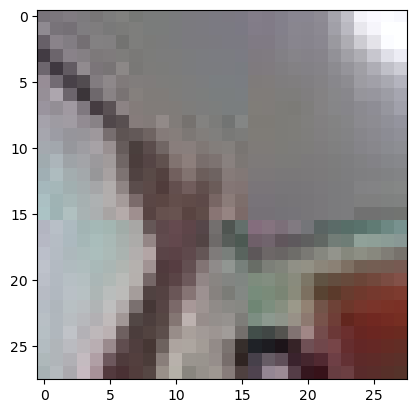

In [7]:
plt.imshow(x_train[200])
print(y_train[200])

딥러닝 네트워크 설계: 1차 시도는 학습자료에 나온대로 적용

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [9]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

In [11]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 1s 6ms/step - loss: 1.0993 - accuracy: 0.3367
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 1.0500 - accuracy: 0.6100
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.9958 - accuracy: 0.5900
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.8873 - accuracy: 0.6800
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.7418 - accuracy: 0.6867
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.5984 - accuracy: 0.7367
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.5429 - accuracy: 0.7467
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 0.4605 - accuracy: 0.8500
Epoch 9/10
10/10 [==============================] - 0s 9ms/step - loss: 0.4577 - accuracy: 0.7800
Epoch 10/10
10/10 [==============================] - 0s 14ms/step - loss: 0.4121 - accuracy: 0.7767


In [12]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 1.3707 - accuracy: 0.4100 - 338ms/epoch - 34ms/step
test_loss: 1.3707098960876465
test_accuracy: 0.4099999964237213


예상했던 대로 높은 수치의 값이 나오지 않았다. 반복하여 돌렸을 때, 0.3에서 0.5 정도의 값이 나왔으며, 0.5가 나왔다고 한들 큰 의미를 두기는 어려워 보인다. 데이터셋, 모델 설계, 매개변수 등 다양한 요소들에 대해 실험해 보도록 하자. 먼저, 가장 쉽게 할 수 있는 매개변수 조작부터 실행해 보았다.

In [13]:
n_channel_1=128
n_channel_2=256
n_dense=50
n_train_epoch=20


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [14]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/20
10/10 [==============================] - 2s 109ms/step - loss: 1.1445 - accuracy: 0.3467
Epoch 2/20
10/10 [==============================] - 1s 122ms/step - loss: 1.0402 - accuracy: 0.4633
Epoch 3/20
10/10 [==============================] - 1s 137ms/step - loss: 0.8252 - accuracy: 0.7067
Epoch 4/20
10/10 [==============================] - 1s 115ms/step - loss: 0.5639 - accuracy: 0.7367
Epoch 5/20
10/10 [==============================] - 1s 109ms/step - loss: 0.4376 - accuracy: 0.7967
Epoch 6/20
10/10 [==============================] - 1s 131ms/step - loss: 0.3741 - accuracy: 0.8600
Epoch 7/20
10/10 [==============================] - 1s 126ms/step - loss: 0.3849 - accuracy: 0.7867
Epoch 8/20
10/10 [==============================] - 1s 130ms/step - loss: 0.3467 - accuracy: 0.8467
Epoch 9/20
10/10 [==============================] - 1s 136ms/step - loss: 0.2591 - accuracy: 0.9033
Epoch 10/20
10/10 [==============================] - 1s 110ms/step - loss: 0.2224 - accuracy: 0.9333

In [15]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 1s - loss: 2.2947 - accuracy: 0.5633 - 952ms/epoch - 95ms/step
test_loss: 2.2947001457214355
test_accuracy: 0.5633333325386047


여러번의 시행을 해봤지만 만족할만한 결과를 얻을 수는 없었다. 모델은 낮게는 0.35, 높게는 0.50 대의 정확도를 보여주었으며, 거의 달라진 것은 없었다. 그래서 통합 데이터셋을 사용하였다.
# 통합 데이터셋 사용

In [16]:
# 통합 데이터셋 변환 한번만 할 것
r_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\rock'
s_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\scissor'
p_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\paper'


resize_images(r_path)
resize_images(s_path)
resize_images(p_path)

C:\Users\wader\AppData\Local\Temp\ipykernel_30980\2826604337.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  sm_img=big_img.resize(target_size, Image.ANTIALIAS)


In [17]:
import numpy as np

def load_data_ent(img_path, number_of_data=7372):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    
    sci_list=os.listdir(img_path+'scissor\\')
    rok_list=os.listdir(img_path+'rock\\')
    pap_list=os.listdir(img_path+'paper\\')
    
    
    for file in sci_list:
        file= img_path+'scissor\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in rok_list:
        file= img_path+'rock\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in pap_list:
        file= img_path+'paper\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [18]:
ent_image_dir_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\'
(x_train, y_train)=load_data_ent(ent_image_dir_path)
x_train_norm = x_train/255.0   

test_dir_path = "C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\test\\rock_scissor_paper\\"
(x_test, y_test)=load_data(test_dir_path)
x_test_norm = x_test/255.0

데이터의 이미지 개수는 7372 입니다.
데이터의 이미지 개수는 300 입니다.


In [19]:
print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (7372, 28, 28, 3)
y_train shape: (7372,)


0


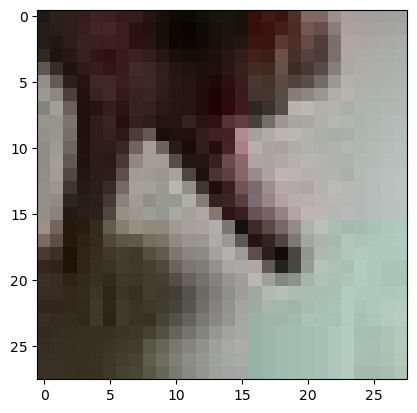

In [20]:
plt.imshow(x_train[500])
print(y_train[500])

In [82]:
# 노드 기본 레이어 및 파라미터로 테스트
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [83]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/10
231/231 [==============================] - 4s 11ms/step - loss: 0.9672 - accuracy: 0.5076
Epoch 2/10
231/231 [==============================] - 2s 10ms/step - loss: 0.6258 - accuracy: 0.7427
Epoch 3/10
231/231 [==============================] - 2s 10ms/step - loss: 0.4377 - accuracy: 0.8303
Epoch 4/10
231/231 [==============================] - 3s 13ms/step - loss: 0.3098 - accuracy: 0.8840
Epoch 5/10
231/231 [==============================] - 2s 8ms/step - loss: 0.2411 - accuracy: 0.9102
Epoch 6/10
231/231 [==============================] - 2s 9ms/step - loss: 0.1922 - accuracy: 0.9327
Epoch 7/10
231/231 [==============================] - 3s 14ms/step - loss: 0.1511 - accuracy: 0.9451
Epoch 8/10
231/231 [==============================] - 3s 13ms/step - loss: 0.1281 - accuracy: 0.9525
Epoch 9/10
231/231 [==============================] - 2s 9ms/step - loss: 0.1039 - accuracy: 0.9630
Epoch 10/10
231/231 [==============================] - 2s 8ms/step - loss: 0.0842 - accuracy: 

In [84]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 1s - loss: 2.4088 - accuracy: 0.6600 - 605ms/epoch - 60ms/step
test_loss: 2.408834218978882
test_accuracy: 0.6600000262260437


혹시 성능을 더 높힐 수 있을까 싶어 파라미터를 변경해 보았다.

In [88]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
# 노드 기본 레이어 및 파라미터로 테스트
n_channel_1=32
n_channel_2=64
n_dense=16
n_train_epoch=15


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [89]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/15
231/231 [==============================] - 5s 19ms/step - loss: 0.9860 - accuracy: 0.4893
Epoch 2/15
231/231 [==============================] - 7s 30ms/step - loss: 0.5958 - accuracy: 0.7592
Epoch 3/15
231/231 [==============================] - 5s 21ms/step - loss: 0.4278 - accuracy: 0.8388
Epoch 4/15
231/231 [==============================] - 5s 20ms/step - loss: 0.3267 - accuracy: 0.8798
Epoch 5/15
231/231 [==============================] - 6s 27ms/step - loss: 0.2504 - accuracy: 0.9084
Epoch 6/15
231/231 [==============================] - 4s 19ms/step - loss: 0.1948 - accuracy: 0.9296
Epoch 7/15
231/231 [==============================] - 4s 16ms/step - loss: 0.1559 - accuracy: 0.9455
Epoch 8/15
231/231 [==============================] - 5s 24ms/step - loss: 0.1217 - accuracy: 0.9574
Epoch 9/15
231/231 [==============================] - 3s 14ms/step - loss: 0.0960 - accuracy: 0.9679
Epoch 10/15
231/231 [==============================] - 3s 14ms/step - loss: 0.0754 - accura

In [90]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 3.3928 - accuracy: 0.6300 - 493ms/epoch - 49ms/step
test_loss: 3.3928141593933105
test_accuracy: 0.6299999952316284


회고  
지금까지 가위바위보 이미지를 인식하고 학습시켜 보았다.  
과제를 진행하며 가장 크게 느낀 점은 데이터의 중요성이다. 직접 만든 사진들을 가지고 학습을 시도했을 때는 아무리 시도해도 0.3에서 0.5 정도의 저조한 성과를 보였고, 과제에서 주어진 매개변수를 아무리 조정해 보아도 뾰족한 성과를 낼 수 없었다. 하지만 다른 사람들의 이미지를 모아 다시 학습을 시도했을 때는 확연한 차이를 볼 수 있었다. 물론 학습을 여러번 진행하다 보면 기준보다 낮은 accuracy를 가지는 경우도 발생했지만 직접 만든 사진들에 대한 이미지 학습보다는 훨씬 accuracy가 높았으며 과제 관련 학습을 진행하였던 화요일 마지막에 '무조건 데이터가 많다고 좋은 것이 아니다'라고 주장했던 것이 생각나 민망함도 느꼈다. 하지만 과제를 진행하던 도중 성주님과 이야기를 나눌 수 있었고, 데이터가 적더라도 충분히 좋은 성과를 낼 수 있다는 사실을 결과를 통해 확인할 수 있었고 결국 데이터는 중요하지만 데이터가 전부는 아니라는 사실을 피부로 경험할 수 있었다.  

두번째로 느낀 점은 노드의 파라미터를 높게 설정한다고 능사가 아니라는 점이다. 과제 baseline에 주어진 파라미터 크기가 작다는 생각에 좀 더 파라미터를 늘려 실행시켜 보았다. conv2의 출력 값은 64에서 512, dense의 unit 값은 64까지 늘려 보았지만 시간만 오래 걸리고 accuracy는 형편없었기 때문이다. 물론 baseline보다 파라미터 크기를 줄여 4~8크기의 파라미터들을 적용시켰을 때는 더더욱 성능이 떨어지긴 했지만, 적정 선 이상이라면 굳이 hidden layer의 출력값을 늘릴 필요는 없다는 결론에 다다를 수 있었다.  

과제에서 아쉬운 점이 있었다면 데이터의 픽셀 수를 늘리는 시도를 하지 못했다는 것이다. 개인적으로 생각했을 때, 데이터의 정확도가 낮은 가장 큰 이유는 이미지의 픽셀이 (28, 28)이라는 작은 크기였기 때문이라고 생각한다. 약간만 확대시켜도 형태가 뭉개지는 이미지로 사람도 알아보기 힘든데, 사람을 흉내낸 기계로 알아보는 일이 여간 어려운 일이 아닌가... 하는 직관적인 생각도 들었고, 학습에 사용하기에는 픽셀 수가 적은 만큼 데이터의 특징도 적을 것이라는 생각이 들었다. 데이터의 특징이 적다는 말은 아무리 학습을 시켜도 가위바위보의 형태를 알아보는데는 한계가 있다는 말이기 때문에 만약 된다면 (224, 224) 혹은 그보다 조금 작은 크기의 이미지를 다뤄보고 싶은 생각이 있었지만 그것까지 하기에는 역부족이었음을 아쉽게 생각한다. 그래도 저번 과제보다는 괜찮은 성과가 나왔기에 만족스럽게 생각한다.